In [42]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random

In [43]:
# Angles (3) + Accel (3) + Compass(3)
#TODO all data input to model
#TODO both IMUS

#Quantity of indexes in input vector width 
data_input_width = 5

#Data is sent in with this many samples of width
time_steps= 10

#Minimum degree value required for an overcompensation measurement
minimum_degree_for_overcomp = 15

#Change this bit to True To train the model otherwise will load from the saved model
train_model = True

#Model Name is the name of the directory to load the model or save a new model to 
model_name = "temp_model"

#Number of times the input data should be trained on 
epochs = 10

#TODO for ensc 440
# Change output of model to:
#   [Abduction Confidence, Flexion Confidence, External Rotation Confidence, Unknown Exercise Confidence, Overcompensation Confidence of identified exercise]
#   ie. The model will make a prediction of what exercise is being performed as well as if that exercise is being performed correctly
#
# Collect data for other exercises and for wrong forms of all exercises
# Detect Start and end of exercise in waveform with multiple exercises, at least run the model on this and see if the output is reasonable

In [44]:
def get_model_for_training():
    model = keras.Sequential()

    # Simple RNN Network takes vector of time_steps elements of which each element is data_input_width wide
    model.add(layers.SimpleRNN(32, input_shape = (time_steps, data_input_width), return_sequences=True))
    model.add(layers.LSTM(16))
    model.add(layers.Dense(10))

    #sigmoid has output between 0 and 1 and represents the confidence of the prediction
    model.add(layers.Dense(1, activation='sigmoid')) 
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [45]:
def convertToMatrix(data, step):
    X = []
    for i in range(len(data) - step):
        d = i+step
        X.append(data[i:d,])
    return np.array(X)

def read_format_csv(filename):
    #TODO does the model perform better with this data?
    #       If so do we need all of the data or just some?
    # ignore_cols = ("time","IMU#", "yaw", "accelx","accely","accelz","compassx","compassy","compassz")
    ignore_cols = ("time","IMU#", "yaw","compassx","compassy","compassz")

    data = pd.read_csv(filename)

    for col in ignore_cols:
        data.pop(col)

    return np.abs(np.array(data))

def get_in(filename0, filename1):
    array0 = read_format_csv(filename0)
    #array1 = read_format_csv(filename1)

    inputs = convertToMatrix(array0, time_steps)
    return inputs

def get_expect(inputs, over_comp):
    if over_comp:
        outputs = np.ones(len(inputs))
        for i, vec in enumerate(inputs):
            outputs[i] = 1 if abs(max(vec[0], key=abs)) > minimum_degree_for_overcomp else 0
    else:
        outputs = np.zeros(len(inputs))
    return outputs

#inputs = get_in("./data/abduction_validate/overcomp/imu0/imu0_21_9__15.csv")
#outputs = get_expect(inputs, 1)
#print(inputs)
#print(outputs)


In [46]:

training_file_names_imu0 = glob("./data/abduction_train/overcomp/imu0/*")
training_file_names_imu0.extend(glob("./data/abduction_train/reg/imu0/*"))

validation_file_names_imu0 = glob("./data/abduction_validate/overcomp/imu0/*")
validation_file_names_imu0.extend(glob("./data/abduction_validate/reg/imu0/*"))

files_per_epoch = len(training_file_names_imu0)
files_per_val = len(validation_file_names_imu0)

training_file_names_imu1 = [i.replace("imu0", "imu1") for i in training_file_names_imu0]
validation_file_names_imu1 = [i.replace("imu0", "imu1") for i in validation_file_names_imu0]

training_index = list(range(0, files_per_epoch))
validation_index = list(range(0, files_per_val))

def training_generator():
    for j in range(epochs):
        random.shuffle(training_index)
        for i in range(files_per_epoch):
            #TODO Input IMU1 Data to model?
            file_name_imu0 = training_file_names_imu0[training_index[i]]
            file_name_imu1 = training_file_names_imu1[training_index[i]]
            temp_in = get_in(file_name_imu0, file_name_imu1)
            temp_out = get_expect(temp_in, "overcomp" in file_name_imu0)
            yield (temp_in, temp_out)

def validation_generator():
     for j in range(epochs):
        random.shuffle(validation_index)
        for i in range(files_per_val):
            file_name_imu0 = validation_file_names_imu0[validation_index[i]]
            file_name_imu1 = validation_file_names_imu1[validation_index[i]]
            temp_in = get_in(file_name_imu0, file_name_imu1)
            temp_out = get_expect(temp_in, "overcomp" in file_name_imu0)
            yield (temp_in, temp_out)




In [47]:
#This line is to get rid of a warning
tf.config.experimental_functions_run_eagerly = False
if train_model:
    model = get_model_for_training()

    model.summary()

    history = model.fit(
        x=training_generator(), 
        epochs=epochs,
        steps_per_epoch=files_per_epoch,
        validation_data=validation_generator(),
        validation_steps=files_per_val,
        validation_freq=2
    )

    model.save(model_name)
else:
    model = keras.models.load_model(model_name)
    



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 10, 32)            1216      
                                                                 
 lstm_3 (LSTM)               (None, 16)                3136      
                                                                 
 dense_6 (Dense)             (None, 10)                170       
                                                                 
 dense_7 (Dense)             (None, 1)                 11        
                                                                 
Total params: 4,533
Trainable params: 4,533
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
129/129 [==============================] - 3s 8ms/step - loss: 0.1530
Epoch 2/10
129/129 [==============================] - 2s 12ms/step - loss: 0.1276 - val_loss: 0.1060
Ep

INFO:tensorflow:Assets written to: temp_model\assets


INFO:tensorflow:Assets written to: temp_model\assets


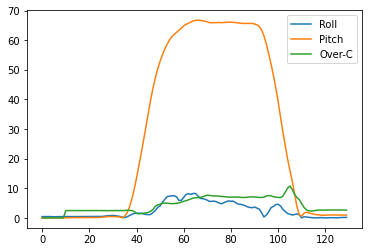

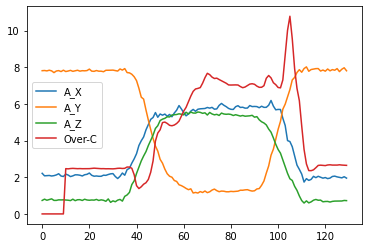

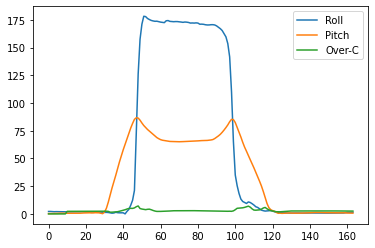

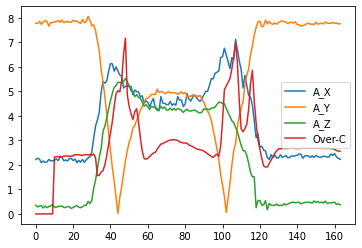

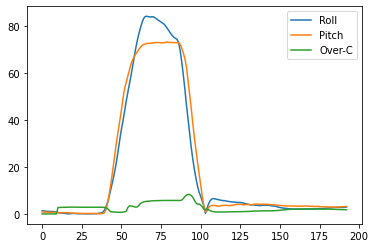

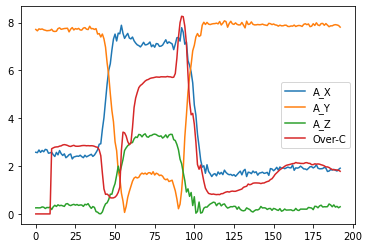

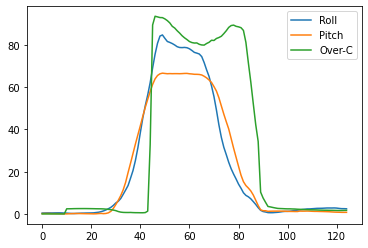

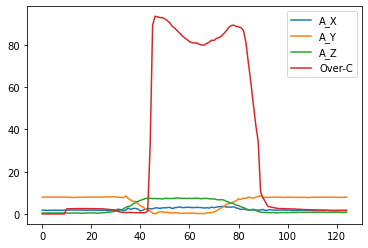

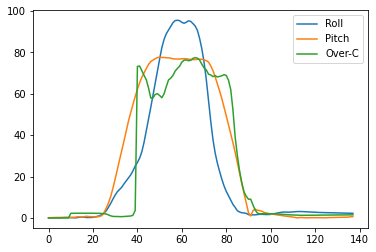

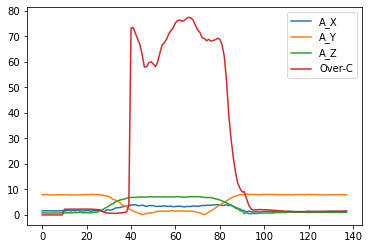

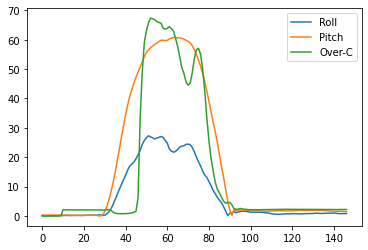

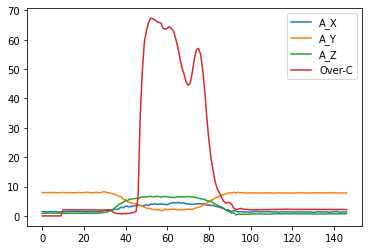

In [58]:
def plot_data_with_predict(filename0, filename1):
    input_data = read_format_csv(filename0)
    # data is [[a0(0), a1(0), a2(0)], [a0(1), a1(1), a2(1)], ... , [a0(n-1), a1(n-1), a2(n-1)]]
    input_data_flat = input_data.flatten()
    # flattened data is [a0(0), a1(0), a2(0), a0(1), a1(1), a2(1), ... , a0(n-1), a1(n-1), a2(n-1)]

    # The following lines makes 3 vectors taking the 3rd entries of the flattened input
    angle0 = input_data_flat[::5]
    angle1 = input_data_flat[1::5]
    accelx = input_data_flat[2::5]
    accely = input_data_flat[3::5]
    accelz = input_data_flat[4::5]

    #angle2 = input_data_flat[2::3]
    #TODO add filename1 data to plot

    data_in = get_in(filename0, filename1) 
    prediction = model.predict(data_in) # Predict the output for the input data

    # Gives vector of 0 to len(angle0) spaced by 1
    x_points = np.arange(0,len(angle0))

    prediction_comp = prediction.flatten()

    # data is fed in 10 points at a time so need to add 10 zero points 
    #   at start of prediction and angle vectors the same length
    for i in range(time_steps):
        prediction_comp = np.insert(prediction_comp, 0, 0)

    # Scale prediction from (0 to 1) to (0 to 100)
    prediction_comp *= 100

    plt.plot(x_points, angle0, label="Roll")
    plt.plot(x_points, angle1, label="Pitch")
    plt.plot(x_points, prediction_comp, label="Over-C")
    plt.legend()
    plt.show()

    plt.plot(x_points, accelx, label="A_X")
    plt.plot(x_points, accely, label="A_Y")
    plt.plot(x_points, accelz, label="A_Z")
    plt.legend()
    plt.show()


#file_name = "./data/abduction_validate/reg/imu0/imu0_18_17__15.csv"
#file_name = "./data/abduction_validate/reg/imu0/imu0_13_32__24.csv"
#file_name = "C:/Users/lukac/Documents/MATLAB/Capstone/TESTING/IMUExperiments/Test1/imu0_18_39__2.csv"
#plot_data_with_predict(file_name, None)
#file_name = "C:/Users/lukac/Documents/MATLAB/Capstone/TESTING/IMUExperiments/Test1/imu0_18_39__3.csv"
#plot_data_with_predict(file_name, None)

for file in glob("C:/Users/lukac/Documents/MATLAB/Capstone/TESTING/IMUExperiments/Test3/imu0*"):
    plot_data_with_predict(file, None)

#print("Start of Overcompensation Runs")
#for file in glob("./data/abduction_validate/overcomp/imu0/*"):
#    plot_data_with_predict(file, None)

#print("Start of Regular Runs")
#for file in glob("./data/abduction_validate/reg/imu0/*"):
#    plot_data_with_predict(file, None)